In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import joblib
import pickle
import time
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb

# Compare CBoW and Skip-gram

The Word2Vec model has to model architectures: the Continuous Bag of Words (CBoW) and the Skip-Gram, in this file we use the CBoW instead of skip-gram and then train the XGBoost with feature vector computed from the W2V model to make prediction, and then compare their performance by examining various metrics, i.e. the accuracy and the auc score.

## Loading data


In [3]:
df=pd.read_pickle('Data/data_cleaned_1')

In [4]:
df

,score,text
0,3.0,"[good, helpfull, read, book, good, type, thats..."
1,1.0,"[sadly, overprice, irrelevant, spite, claim, i..."
2,2.0,"[endless, rant, howard, borrow, dennis, miller..."
3,1.0,"[not, quite, hip, really, shame, time, reserch..."
4,5.0,"[journey, centre, earth, hey, great, book, abs..."
...,...,...
49995,5.0,"[star, short, easy, explanation, follow, lot, ..."
49996,5.0,"[michael, hague, illustration, best, buy, love..."
49997,5.0,"[quot, american, beauty, quot, novel, dark, co..."
49998,4.0,"[funny, quirky, really, funny, witty, book, su..."


## Fit the w2v model with sg=CBoW(0)

In [5]:
vector_size=1000
#The number of dimensions of embeddings, the default is 100
window=3
#The maximum distance between a target word and its neighbours, default is 5
min_count=3
#The minimum counts of words in order for the word to be considered for the training of model, default is 5
workers=3
#The number of partitions during training, default is 3
sg=0
#The training algorithom, either CBOW(0) or skip gram(1), default is CBOW

#tokens = pd.Series(df['tokenized_text']).values
start_t = time.time()
w2vmodel=Word2Vec(df['text'],min_count=min_count,vector_size=vector_size,workers=workers,sg=sg)
print('Time taken to train word2vec model:' +str(time.time()-start_t))

Time taken to train word2vec model:38.69509315490723


We can see the training time for W2V with CBoW is a lot shorter than W2V with skip gram.

In [6]:
word2vec_model_file = '/Users/xin/Library/CloudStorage/OneDrive-UniversityofBristol/DST/DST_Assessment2/Xin/Data/' + 'word2vec_2' + '.model'
w2vmodel.save(word2vec_model_file)

In [7]:
w2v_model = Word2Vec.load(word2vec_model_file) 
#we have to save and load for some of the function below to work

## Extract the outputs of w2v model

https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

how to put the outputs of word2vec into data frame, and apply PCA on the outputs

In [8]:
emb_df = (
    pd.DataFrame(
        [w2v_model.wv.get_vector(str(n)) for n in w2vmodel.wv.key_to_index],
        index = w2vmodel.wv.key_to_index
    )
)
print(emb_df.shape)

emb_df.head()

(36738, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
book,-0.253921,0.007940,0.433629,0.333751,-0.129779,0.116287,0.406918,0.043796,-0.307826,-0.531695,...,-0.009229,0.173578,-0.338392,0.247634,0.402454,-0.307052,-0.179264,0.303243,0.489059,0.335967
not,-0.209543,-0.316898,0.414101,-0.285708,-0.594602,-0.374296,-0.113977,-0.250304,-0.056806,-0.406552,...,0.070347,-0.507486,-0.442185,0.354828,-0.303378,0.012586,0.156392,0.363412,0.228693,0.483637
read,-0.311027,0.295913,0.167437,0.360623,0.109677,0.200109,-0.313538,-0.170187,0.062062,-0.265991,...,0.112416,0.138460,-0.289697,0.460239,-0.349767,0.500807,0.028558,0.213253,-0.135733,0.810639
one,-0.351957,0.219230,0.396524,0.236601,-0.262886,-0.070493,0.099000,-0.302694,-0.362885,0.045302,...,-0.038956,-0.081863,-0.443932,-0.041679,-0.095197,-0.065554,-0.215159,0.628756,0.310091,0.438491
story,-0.051308,0.066355,0.580810,0.170865,0.126754,-0.616359,0.335626,-0.371040,-0.005304,-0.232113,...,0.246067,-0.265161,0.318121,-0.356808,0.842104,0.451485,-0.297985,0.258182,0.188731,-0.586740


In [9]:
print(w2v_model.wv.most_similar('wonderful'))

[('fantastic', 0.8484282493591309), ('fabulous', 0.7944499850273132), ('amazing', 0.7848646640777588), ('awesome', 0.7475287318229675), ('amaze', 0.7410269379615784), ('delightful', 0.728579580783844), ('marvelous', 0.718217134475708), ('terrific', 0.7136596441268921), ('incredible', 0.6889655590057373), ('inspirational', 0.6860165596008301)]


In [11]:
print("Cosine similarity between 'wonderful' " +
               "terrible' - CBoW : ",
    w2v_model.wv.similarity('wonderful', 'bad'))

Cosine similarity between 'wonderful' terrible' - CBoW :  0.0067944583


We can see that the result above already shows the difference with the two different model arhitectures, the values of CBoW seem to be slightly more extreme than the ones of skip-gram.

[]

<Figure size 640x480 with 0 Axes>

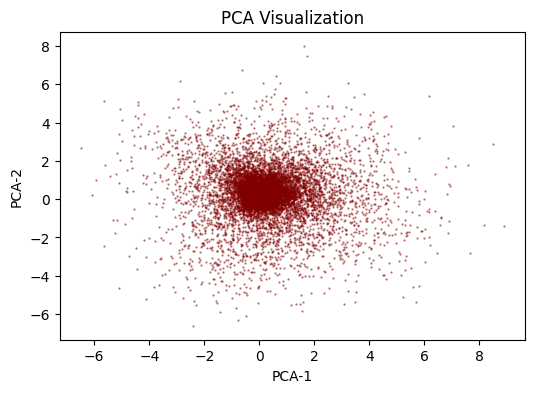

In [12]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

## Train test data split

Use the same train test data set, to make the comparison fair

In [14]:
X_train=pd.read_pickle('Data/X_train')
X_test=pd.read_pickle('Data/X_test')
y_train=pd.read_pickle('Data/y_train')
y_test=pd.read_pickle('Data/y_test')

## Compute feature vectors for each review

https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec/notebook
 define functions to compute feature vectors, which is an average of the vectors of each word appeared in the review, and the feature vectors can be then be used as inputs for the classification model.

In [15]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index_to_key)
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    
    if nwords ==0:
        featureVec = np.zeros(1000)
        #avoiding divide by zero, define it as a all zero vector
    else:
        featureVec = np.divide(featureVec, nwords)
    # Dividing the result by number of words to get average

    return featureVec

In [16]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Comment %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
            
        counter = counter+1
        
    return reviewFeatureVecs

In [18]:
X_train

,index,text
0,45570,"[multidimensional, thought, book, good, job, p..."
1,21855,"[magnetic, influence, success, business, find,..."
2,41127,"[read, weep, world, full, bad, book, write, am..."
3,4849,"[clear, channel, watt, book, great, show, book..."
4,20742,"[page, miss, line, mass, market, paperback, ed..."
...,...,...
39995,39296,"[euphoric, sandra, cisneros, not, writershe, m..."
39996,49015,"[keep, get, well, start, first, leave, behind,..."
39997,2693,"[new, age, twaddle, here, good, book, not, sur..."
39998,8076,"[enlighten, new, biography, read, everything, ..."


The two functions above will raise an error message of dividing by 0 if nwords=0, this is because the wv2 model has min_count set to 3, sometimes all the words appearing in a review turn out to have count less than 3, this could be due to spelling errors and various other reasons.

Therefore, I have added a line of if boolean in the featureVecMethod function, which set the vector to all zeros when nwords=0. And it can be then identified later.

In [19]:
trainDataVecs = getAvgFeatureVecs(X_train['text'], w2v_model, 1000)
#get feature vectors for train data

Comment 0 of 40000
Comment 1000 of 40000
Comment 2000 of 40000
Comment 3000 of 40000
Comment 4000 of 40000
Comment 5000 of 40000
Comment 6000 of 40000
Comment 7000 of 40000
Comment 8000 of 40000
Comment 9000 of 40000
Comment 10000 of 40000
Comment 11000 of 40000
Comment 12000 of 40000
Comment 13000 of 40000
Comment 14000 of 40000
Comment 15000 of 40000
Comment 16000 of 40000
Comment 17000 of 40000
Comment 18000 of 40000
Comment 19000 of 40000
Comment 20000 of 40000
Comment 21000 of 40000
Comment 22000 of 40000
Comment 23000 of 40000
Comment 24000 of 40000
Comment 25000 of 40000
Comment 26000 of 40000
Comment 27000 of 40000
Comment 28000 of 40000
Comment 29000 of 40000
Comment 30000 of 40000
Comment 31000 of 40000
Comment 32000 of 40000
Comment 33000 of 40000
Comment 34000 of 40000
Comment 35000 of 40000
Comment 36000 of 40000
Comment 37000 of 40000
Comment 38000 of 40000
Comment 39000 of 40000


In [21]:
def remove_unuseful_rows(trainDataVecs,y_train):
    list=[]
    y_train.reset_index()
    for i in range(trainDataVecs.shape[0]):
        if np.all(trainDataVecs[i,]==0):
            list.append(i)
    if len(list)!=0:
        trainDataVecs=np.delete(trainDataVecs,list,axis=0)
        y_train.drop(index=list,inplace=True)
    return trainDataVecs,y_train
# remove the sample with all zero vector and its corresponding y

In [27]:
trainDataVecs.dump('Data/trainDataVecs_CBoW')

In [28]:
trainDataVecs=pd.read_pickle('Data/trainDataVecs_CBoW')

In [22]:
trainDataVecs1,y_train1=remove_unuseful_rows(trainDataVecs,y_train)

In [23]:
y_train1.shape

(39999, 2)

In [24]:
trainDataVecs1.shape

(39999, 1000)

We only want to classify if the review is good or bad, here I create a new label 'sentiment', it equals to 0 if the review is bad(i.e. the raing is less or equals to 3), and equals to 1 otherwise.

In [25]:
y_train1['sentiment'] = 0

In [27]:
y_train1=y_train1.reset_index(drop=True)

In [28]:
for i in range(y_train1.shape[0]):
    if y_train1['score'][i] > 3:
        y_train1['sentiment'][i] = 1

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_24206/2132215972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train1['sentiment'][i] = 1


## XGBoost Classification model

Here, we train the XGBoost model with the input feature vector computed from the outputs of W2V with CBoW, and we want to compare the performance with feature vector computed from the outputs of W2V with skip-gram. We compare both accuracy and AUC score.

In [29]:
xgb_model = xgb.XGBClassifier(
    max_depth = 9, 
    min_child_weight = 1, 
    gamma = 0.4, 
    subsample=0.9, 
    colsample_bytree = 0.9,
    learning_rate =0.2,
    n_estimators=300)


start_time = time.time()
xgb_model.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the demodel with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the demodel with word2vec vectors: 524.496169090271


https://xgboost.readthedocs.io/en/stable/python/python_api.html
information about xgboost

In [30]:
filename='xgb_model_cbow.joblib'
joblib.dump(xgb_model,filename)

['xgb_model_cbow.joblib']

In [31]:
xgb_model=joblib.load('xgb_model_cbow.joblib')

## Test data set

We start with process the test data set just like we did for the train data, i.e. compute feature vectors, remove rows that divide by zero, and etc.

In [32]:
testDataVecs = getAvgFeatureVecs(X_test['text'], w2v_model, 1000)

Comment 0 of 10000
Comment 1000 of 10000
Comment 2000 of 10000
Comment 3000 of 10000
Comment 4000 of 10000
Comment 5000 of 10000
Comment 6000 of 10000
Comment 7000 of 10000
Comment 8000 of 10000
Comment 9000 of 10000


In [33]:
y_test=y_test.reset_index(drop=True)

In [34]:
testDataVecs1,y_test1=remove_unuseful_rows(testDataVecs,y_test)

In [35]:
y_test1['sentiment']=0
for i in range(y_test1.shape[0]):
    if y_test1['score'][i] > 3:
        y_test1['sentiment'][i] = 1

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_24206/1742227497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['sentiment'][i] = 1


In [36]:
xgb_prediction=xgb_model.predict(testDataVecs1)

In [37]:
np.dot(xgb_prediction-y_test1['sentiment'],xgb_prediction-y_test1['sentiment'])

1424

In [39]:
print(classification_report(y_test1['sentiment'],xgb_prediction))

              precision    recall  f1-score   support

           0       0.72      0.47      0.57      1995
           1       0.88      0.95      0.91      8005

    accuracy                           0.86     10000
   macro avg       0.80      0.71      0.74     10000
weighted avg       0.85      0.86      0.85     10000



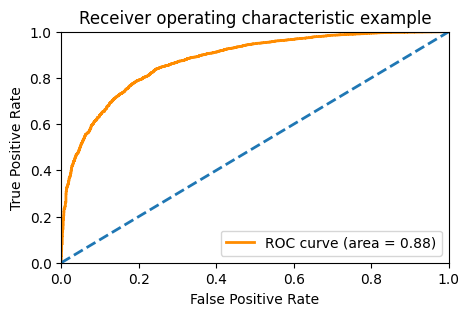

In [41]:
y_pred = [x[1] for x in xgb_model.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test1['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The mean square error incresed quite significantly from 1293 to 1424, the accuracy and the auc score has decreased slightly. The CBoW has worse performance for the infrequent words compared to skip-gram. Therefore, when the size of dataset is small or the budget is limited, skip-gram is preferable to CBoW.